7/5/2019

Generating close, split, and far conditions for each of the games in the train/dev/test data.

To generate colors, we use rejection sampling. We choose a color as our target. Then we sample distractor colors in RGB space and calculate the distance between each color and the target. Depending on the condition that the target is a part of, we keep the number of sampled colors close to and far from the target to construct the remaining two conditions.

In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [27]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
from evaluation import delta_e_dist

In [8]:
import numpy as np
import copy                   # for deepcopy
import random                 # for randrange
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [114]:
train_data_small = train_data[:10]

In [45]:
COLOR_DIST_THRESHOLD   = 20 # from Monroe et al., 2017
COLOR_DIST_LOWER_BOUND = 5  # from Monroe et al., 2017

In [296]:
def sample_rgb():
    return [random.randrange(256) for _ in range(3)]

def sample_rgb_norm():
    return np.array(sample_rgb()) / 256

def sample_rgb_discrete(chunks=32):
    rgb_vals = np.arange(1, chunks)*(256/chunks) # don't choose 0 or chunks
    return [random.choice(rgb_vals) for  _ in range(3)]

def sample_rgb_discrete_norm(chunks=32):
    return np.array(sample_rgb_discrete(chunks)) / 256


In [289]:
sample_rgb_discrete_norm()

array([0.9375 , 0.59375, 0.625  ])

In [300]:
sample_rgb_norm()

array([0.640625  , 0.68359375, 0.45703125])

In [293]:
random.choice([1, 31, 32])

32

In [162]:
def calculate_color_distance(color1, color2):
    return delta_e_dist(np.array(color1.rgb_norm), np.array(color2.rgb_norm))

In [361]:
def sample_color(close=[], far=[]):
    """
    Sample color close to and far from given colors using rejection sampling
    
    Args:
        close: list of colors the sampled color should be close to
        far: list of colors the sampled color should be far from
        
    Returns:
        returns a Color (monroe_data.Color object) containing sampled color
    """
    num_rejections = 0
    while True:
        candidate_rgb = np.array(sample_rgb_discrete_norm(chunks=128))
        
        close_distances = np.array([delta_e_dist(candidate_rgb, np.array(close_color.rgb_norm)) for close_color in close])
        far_distances = np.array([delta_e_dist(candidate_rgb, np.array(far_color.rgb_norm)) for far_color in far])
        
        # Check that candidate color respects distance constraints given by close and far
        # Note: all([]) => True
        candidate_passes = all(close_distances > COLOR_DIST_LOWER_BOUND)
        candidate_passes = candidate_passes and all(close_distances < COLOR_DIST_THRESHOLD)
        candidate_passes = candidate_passes and all(far_distances > COLOR_DIST_THRESHOLD)
        
        if candidate_passes:
            candidate_color = Color(*(256 * candidate_rgb), space="rgb")
            #print(num_rejections)
            return candidate_color
        num_rejections += 1
        if num_rejections > 10000:
            print("Mistake after rejection", num_rejections, close, far, candidate_rgb)
            return Color(*(256 * candidate_rgb), space="rgb")
            #print("MANY REJECTIONS")
            #print(candidate_rgb)
            #print(close_distances, far_distances)
            #num_rejections = 0

        
    
    

In [42]:
ciede_scores = [calculate_color_distance(Color(*sample_rgb(), "rgb"), Color(*sample_rgb(), "rgb")) for _ in range(1000)]

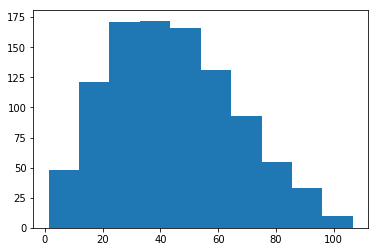

In [43]:
plt.hist(ciede_scores)
plt.show()

In [188]:
import time

In [190]:
save_time = time.time()

In [193]:
time.time() - save_time

16.223710775375366

In [386]:
%%time
all_condition_prediction_entries = []
all_conditions = {"close", "split", "far"}

start_time = time.time()
# iterate through data entries
for i, de in enumerate(dev_data):
    if i%100 == 0:
        print(f"{(time.time() - start_time):.2f}s:\t{(100 * i/len(train_data)):.2f}% done!")
    target_color = de.colors[0]
    
    conditions_needed = all_conditions - {de.condition}
    generated_colors = {}
    
    # generate the colors for the conditions we need
    if "close" in conditions_needed:
        dist1 = sample_color(close=[target_color])
        dist2 = sample_color(close=[target_color, dist1])
        generated_colors["close"] = [dist1, dist2]  
        
    if "split" in conditions_needed:
        dist1 = sample_color(close=[target_color])
        dist2 = sample_color(far=[target_color, dist1])
        generated_colors["split"] = [dist1, dist2]
    
    if "far" in conditions_needed:
        dist1 = sample_color(far=[target_color])
        dist2 = sample_color(far=[target_color, dist1])
        generated_colors["far"] = [dist1, dist2]
    
    
    # add all conditions to new data entries and add data entries to master list
    # add first entry
    all_condition_prediction_entries.append(copy.deepcopy(de))
    
    # add generated colors
    for condition, distractors in generated_colors.items():
        new_entry = copy.deepcopy(de)
        new_entry.colors = [target_color, *distractors]
        new_entry.condition = condition
        all_condition_prediction_entries.append(new_entry)
    

           

0.00s:	0.00% done!
2.08s:	0.64% done!
4.05s:	1.28% done!
5.60s:	1.92% done!
7.94s:	2.55% done!
9.51s:	3.19% done!
11.56s:	3.83% done!
13.31s:	4.47% done!
14.96s:	5.11% done!
16.66s:	5.75% done!
18.71s:	6.38% done!
20.36s:	7.02% done!
22.24s:	7.66% done!
23.98s:	8.30% done!
25.79s:	8.94% done!
27.71s:	9.58% done!
29.39s:	10.21% done!
31.18s:	10.85% done!
33.30s:	11.49% done!
35.21s:	12.13% done!
37.30s:	12.77% done!
39.05s:	13.41% done!
40.70s:	14.04% done!
42.66s:	14.68% done!
44.68s:	15.32% done!
46.60s:	15.96% done!
48.40s:	16.60% done!
50.46s:	17.24% done!
52.26s:	17.87% done!
54.07s:	18.51% done!
55.85s:	19.15% done!
57.93s:	19.79% done!
59.76s:	20.43% done!
61.66s:	21.07% done!
63.86s:	21.70% done!
65.68s:	22.34% done!
67.54s:	22.98% done!
69.29s:	23.62% done!
70.86s:	24.26% done!
72.62s:	24.90% done!
74.47s:	25.53% done!
76.16s:	26.17% done!
78.10s:	26.81% done!
79.76s:	27.45% done!
81.85s:	28.09% done!
83.35s:	28.73% done!
85.29s:	29.36% done!
87.31s:	30.00% done!
89.15s:	30.64%

In [420]:
with open("../data/entries/train_entries_condition_prediction.pkl", "rb") as infile:
    all_condition_prediction_entries = pkl.load(infile)

In [ ]:
len

In [421]:
len(all_condition_prediction_entries)

46995

In [422]:
distractor_distances = [(de.condition, calculate_color_distance(de.colors[1], de.colors[2])) for de in all_condition_prediction_entries]
for i, cd in enumerate(distractor_distances):
    if i%3 == 0: continue
    condition, distance = cd
    if condition == "close" and distance > COLOR_DIST_THRESHOLD:
        print(i)
    elif condition == "far" and distance < COLOR_DIST_THRESHOLD:
        print(i)
    elif condition == "split" and distance < COLOR_DIST_THRESHOLD:
        print(i)


In [423]:
target_dist1_distances = [(de.condition, calculate_color_distance(de.colors[0], de.colors[1])) for de in all_condition_prediction_entries]
for i, cd in enumerate(target_dist1_distances):
    if i % 3 == 0: continue
    condition, distance = cd
    if condition == "close" and distance > COLOR_DIST_THRESHOLD:
        print("close", i, int(distance))
    elif condition == "far" and distance < COLOR_DIST_THRESHOLD:
        print("far", i, int(distance))

In [424]:
target_dist2_distances = [(de.condition, calculate_color_distance(de.colors[0], de.colors[2])) for de in all_condition_prediction_entries]
for i, cd in enumerate(target_dist2_distances):
    if i % 3 == 0: continue
    condition, distance = cd
    if condition == "close" and distance > COLOR_DIST_THRESHOLD:
        print(i, distance)
    elif condition == "far" and distance < COLOR_DIST_THRESHOLD:
        print(i, distance)

In [393]:
for i in range(len(target_dist1_distances)):
    if i%3 == 0: continue
    if target_dist1_distances[i][0] == "split":
        if (target_dist1_distances[i][1] > COLOR_DIST_THRESHOLD and\
        target_dist2_distances[i][1] < COLOR_DIST_THRESHOLD) or (target_dist1_distances[i][1] < COLOR_DIST_THRESHOLD and\
        target_dist2_distances[i][1] > COLOR_DIST_THRESHOLD):
            continue
        else:
            print(i, target_dist1_distances[i][1], target_dist2_distances[i][1])

In [388]:
all_cp_conditions = [de.condition for de in all_condition_prediction_entries]

In [390]:
all(all_cp_conditions[::3] == dev_data.data.condition)

True

In [372]:
train_data.data.condition[:10]

0    close
1      far
2    close
3    split
4      far
5      far
6    split
7    split
8    split
9      far
Name: condition, dtype: object

In [63]:
NUM_CONDITIONS = 3

In [426]:
len(all_condition_prediction_entries)

46995

In [425]:
len(distractor_distances)

46995

In [427]:
%%time
# turn the entry list into a dataframe - no fields are reliable other than color and caption :(

condition_prediction_df = pd.DataFrame(index=list(range(len(all_condition_prediction_entries))), columns=train_data.data.columns)


start_time = time.time()
for round_num, de in enumerate(all_condition_prediction_entries):
    if round_num % 100 == 0:
        print(f"{(time.time() - start_time):.2f}s:\t{(100 * round_num/len(all_condition_prediction_entries)):.2f}% done!")
    
    condition_prediction_df.loc[round_num] = train_data.data.loc[round_num // NUM_CONDITIONS]
    condition_prediction_df.loc[round_num, "gameid"] = "{}_{}".format(
        condition_prediction_df.loc[round_num, "gameid"], round_num % NUM_CONDITIONS)
    condition_prediction_df.loc[round_num, "condition"] = de.condition

    # update the distractor colors if entry isn't first in its group of 3
    if round_num % NUM_CONDITIONS != 0:
        dist1h, dist1s, dist1l = de.colors[1].hsl
        dist2h, dist2s, dist2l = de.colors[2].hsl
        
        dist1_maps_to, dist2_maps_to = None, None
        for label in ["click", "alt1", "alt2"]:
            status = condition_prediction_df.loc[round_num, f"{label}Status"]
            if status == "distr1":
                dist1_maps_to = label
            elif status == "distr2":
                dist2_maps_to = label
        
#         if de.target_idx == de.click_idx:
#             # click index is target, so we don't change it
#             dist1_maps_to = "alt1"
#             dist2_maps_to = "alt2"
            
#         else:
#             # this is a bit convoluted because in the csv, what's recorded is the clicked color and the alternate 
#             # colors, so if the clicked color isn't the target, we have to figure out which alternate color is the target
#             # and not replace that one
#             dist1_maps_to = "click"
            
#             if condition_prediction_df.loc[round_num, "alt1Status"] == "target":
#                 # alternate color 1 is target, so replace alternate color 2
#                 dist2_maps_to = "alt2"
#                 # non target is click and alt2
                
#             else:
#                 # alternate color 2 is target, so replace alternate color 1
#                 dist2_maps_to = "alt1"
        
        
        condition_prediction_df.loc[round_num, f"{dist1_maps_to}ColH"] = dist1h
        condition_prediction_df.loc[round_num, f"{dist1_maps_to}ColS"] = dist1s
        condition_prediction_df.loc[round_num, f"{dist1_maps_to}ColL"] = dist1l
        
        condition_prediction_df.loc[round_num, f"{dist2_maps_to}ColH"] = dist2h
        condition_prediction_df.loc[round_num, f"{dist2_maps_to}ColS"] = dist2s
        condition_prediction_df.loc[round_num, f"{dist2_maps_to}ColL"] = dist2l
        
        condition_prediction_df.loc[round_num, f"targetD1Diff"] = int(target_dist1_distances[round_num][1])
        condition_prediction_df.loc[round_num, f"targetD2Diff"] = int(target_dist2_distances[round_num][1])
        condition_prediction_df.loc[round_num, f"D1D2Diff"] = int(distractor_distances[round_num][1])

0.00s:	0.00% done!
0.16s:	0.21% done!
0.32s:	0.43% done!
0.47s:	0.64% done!
0.64s:	0.85% done!
0.82s:	1.06% done!
0.97s:	1.28% done!
1.12s:	1.49% done!
1.30s:	1.70% done!
1.44s:	1.92% done!
1.62s:	2.13% done!
1.80s:	2.34% done!
1.94s:	2.55% done!
2.09s:	2.77% done!
2.29s:	2.98% done!
2.44s:	3.19% done!
2.61s:	3.40% done!
2.80s:	3.62% done!
2.99s:	3.83% done!
3.16s:	4.04% done!
3.32s:	4.26% done!
3.48s:	4.47% done!
3.64s:	4.68% done!
3.79s:	4.89% done!
3.98s:	5.11% done!
4.14s:	5.32% done!
4.28s:	5.53% done!
4.43s:	5.75% done!
4.59s:	5.96% done!
4.74s:	6.17% done!
4.88s:	6.38% done!
5.05s:	6.60% done!
5.21s:	6.81% done!
5.37s:	7.02% done!
5.53s:	7.23% done!
5.73s:	7.45% done!
5.89s:	7.66% done!
6.03s:	7.87% done!
6.19s:	8.09% done!
6.33s:	8.30% done!
6.48s:	8.51% done!
6.65s:	8.72% done!
6.81s:	8.94% done!
6.96s:	9.15% done!
7.11s:	9.36% done!
7.26s:	9.58% done!
7.40s:	9.79% done!
7.55s:	10.00% done!
7.71s:	10.21% done!
7.84s:	10.43% done!
7.99s:	10.64% done!
8.13s:	10.85% done!
8.30s:	

59.65s:	84.26% done!
59.80s:	84.48% done!
59.94s:	84.69% done!
60.08s:	84.90% done!
60.23s:	85.12% done!
60.37s:	85.33% done!
60.51s:	85.54% done!
60.65s:	85.75% done!
60.81s:	85.97% done!
60.95s:	86.18% done!
61.09s:	86.39% done!
61.24s:	86.60% done!
61.38s:	86.82% done!
61.53s:	87.03% done!
61.67s:	87.24% done!
61.81s:	87.46% done!
61.95s:	87.67% done!
62.10s:	87.88% done!
62.24s:	88.09% done!
62.38s:	88.31% done!
62.53s:	88.52% done!
62.68s:	88.73% done!
62.82s:	88.95% done!
62.97s:	89.16% done!
63.12s:	89.37% done!
63.25s:	89.58% done!
63.40s:	89.80% done!
63.54s:	90.01% done!
63.68s:	90.22% done!
63.83s:	90.44% done!
63.97s:	90.65% done!
64.11s:	90.86% done!
64.26s:	91.07% done!
64.40s:	91.29% done!
64.55s:	91.50% done!
64.69s:	91.71% done!
64.84s:	91.92% done!
64.98s:	92.14% done!
65.13s:	92.35% done!
65.27s:	92.56% done!
65.41s:	92.78% done!
65.56s:	92.99% done!
65.70s:	93.20% done!
65.85s:	93.41% done!
65.99s:	93.63% done!
66.13s:	93.84% done!
66.28s:	94.05% done!
66.42s:	94.27

In [428]:
condition_prediction_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
gameid,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,1,1,2,2,2,3,3,3,4
condition,close,split,far,far,close,split,close,split,far,split
clickStatus,distr2,distr2,distr2,target,target,target,distr2,distr2,distr2,distr1
clickColH,248,27,337,249,249,249,291,214,334,85
clickColS,92,54,84,25,25,25,59,77,14,21
clickColL,50,68,50,50,50,50,50,38,45,50
clickLocS,3,3,3,1,1,1,3,3,3,2
clickLocL,1,1,1,2,2,2,3,3,3,1


In [409]:
condition_prediction_df.alt1Status

0        distr2
1        distr2
2        distr2
3        distr2
4        distr2
5        distr2
6        distr2
7        distr2
8        distr2
9        distr1
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
46980       NaN
46981       NaN
46982       NaN
46983       NaN
46984       NaN
46985       NaN
46986       NaN
46987       NaN
46988       NaN
46989       NaN
46990       NaN
46991       NaN
46992       NaN
46993       NaN
46994       NaN
46995       NaN
46996       NaN
46997       NaN
46998       NaN
46999       NaN
47000       NaN
47001       NaN
47002       NaN
47003       NaN
47004       NaN
47005       NaN
47006       NaN
47007       NaN
47008       NaN
47009       NaN
Name: alt1Status, Length

In [416]:
condition_prediction_df[3, "alt1Status"]

KeyError: (3, 'alt1Status')

In [403]:
dev_data.data.head().T

,0,1,2,3,4
gameid,2641-2,2641-2,2641-2,2641-2,2641-2
clkTime,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12
roundNum,1,2,3,4,5
condition,split,split,far,split,far
clickStatus,target,target,target,target,target
clickColH,48,66,336,172,41
clickColS,13,26,24,60,71
clickColL,50,50,50,50,50
clickLocS,2,3,2,1,1
clickLocL,1,3,2,1,2


In [140]:
condition_prediction_df.shape

(46995, 36)

In [141]:
len(train_data)*3

46995

In [429]:
condition_prediction_df.to_csv("../data/csv/train_corpus_condition_prediction.csv", header=True, index=False)

In [418]:
# import pickle as pkl
# with open("../data/entries/dev_entries_condition_prediction.pkl", "wb") as pkl_file:
#     pkl.dump(all_condition_prediction_entries, pkl_file)

Ok, so I messed this up a little bit by not taking into account the distance between distractors when augmenting these datasets. In the `close` condition, ALL colors have to be close. Similarly, in the `far` condition, ALL colors have to far. I'm not sure about distance between distractors in the `split` condition, so I'm going to measure that now (in bottom of "Condition Prediction Pragmatic" notebook). 

Ok, so it turns out inthe `split` condition the distractors are also far from each other, so I have to implement that.

Also, it would probably be good to update the dataframe with the actual distances from targets / distractors

Ok, after a day of work, it's fixed (hopefully, I think)